# create mlp to do regression
- data preparation
- data processing
- create model
- train the model
- visualize the result

In [1]:
import torch
import numpy as np
import pandas as pd
datafile = './data.txt'

## 1.data preparation

In [2]:
df = pd.read_csv(datafile, delim_whitespace=True)
df.head()

,Tsys,OutW,OutK,In1,In2,In3,In4,In5
0,14260.207347,-4.372067,1.684068,-90.0,5092.174480,7.568569,7.603383,2.766608e-05
1,17860.113750,-4.395031,1.684086,-90.0,5092.248508,7.733917,7.755043,3.147119e-06
2,21460.017344,-4.396948,1.684095,-90.0,5092.285155,7.800454,7.824474,5.493316e-14
3,25059.939097,-4.466899,1.684189,-90.0,5092.464156,8.715562,8.791684,2.609611e-04
4,28659.869252,-4.604535,1.684474,-90.0,5093.527380,11.173874,11.232197,2.440854e-04


# 2.data processing

In [3]:
# obj: ln1,ln2 -> outW
x_columns = ['In1', 'In2']
y_columns = ['OutW']
df = df[x_columns+y_columns].astype('float32')

In [4]:
# norm x columns, maybe we can norm y columns too
for col in x_columns:
    df[col] = (df[col]-df[col].mean())/df[col].std()

In [5]:
df[x_columns+y_columns].head()

,In1,In2,OutW
0,-1.711012,-1.654461,-4.372067
1,-1.711012,-1.640451,-4.395031
2,-1.711012,-1.633539,-4.396948
3,-1.711012,-1.599714,-4.466899
4,-1.711012,-1.399070,-4.604535


In [6]:
df.dtypes

In1     float32
In2     float32
OutW    float32
dtype: object

# 3.create model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_channel=2):
        super().__init__()
        self.fc_1 = nn.Linear(input_channel, 10, bias=True)
        self.fc_2 = nn.Linear(10, 5, bias=True)
        self.fc_3 = nn.Linear(5, 1, bias=True)
    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [8]:
model = Model(2)

# 4.train the model

In [9]:
# spilt the data to train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=0)
train = train.reset_index()
test = test.reset_index()
train.head()

,index,In1,In2,OutW
0,3822,1.617847,-0.072258,-4.989700
1,2535,0.476524,0.325805,-3.912555
2,2515,0.476524,-0.855848,-3.569416
3,3768,1.570292,-0.072258,-4.953027
4,713,-1.092795,-0.944603,-4.725879


In [10]:
# train and test data to dataloader
cnt = 0
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        global cnt
        x = torch.tensor(row[x_columns]).float()
        y = torch.tensor(row[y_columns]).float()
        if cnt==0:
            print(row)
            cnt += 1
        return x, y
trainset = Dataset(train)
testset = Dataset(test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

In [17]:
import torch.nn as nn
import tqdm
epochs = 20
optim = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
trainloss = []
validloss = []
def train_epoch(loader):
    losses = []
    for x, y in loader:
        out = model(x)
        loss = loss_func(out, y)
        losses.append(loss)
        optim.zero_grad()
        loss.backward()
        optim.step()
    return sum(losses)/len(losses)

@torch.no_grad()
def test_epoch(loader):
    losses = []
    for x, y in loader:
        out = model(x)
        loss = loss_func(out, y)
        losses.append(loss)
    return sum(losses)/len(losses)

train_loss_list = []
valid_loss_list = []

tbar = tqdm.trange(epochs)
for epoch in tbar:
    trainloss = train_epoch(trainloader)
    validloss = test_epoch(testloader)
    train_loss_list.append(trainloss)
    valid_loss_list.append(validloss)
    tbar.set_description(f'trainloss: {trainloss:.4f}, validloss: {validloss:.4f}')


trainloss: 0.0524, validloss: 0.0535: 100%|██████████| 20/20 [04:07<00:00, 12.39s/it]


# 5.Visualize the result

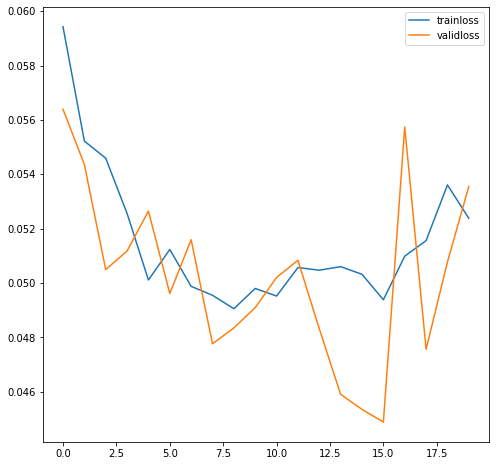

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(train_loss_list, label='trainloss')
plt.plot(valid_loss_list, label='validloss')
plt.legend()
plt.show()